In [2]:
import argparse

import numpy as np
import autograd.numpy as npa

import matplotlib as mpl
mpl.rcParams['figure.dpi']=100

import matplotlib.pylab as plt

from autograd.scipy.signal import convolve as conv
from skimage.draw import circle

import ceviche
from ceviche import fdfd_ez, fdfd_ez_nl, jacobian
from ceviche.optimizers import adam_optimize
from ceviche.utils import imarr, get_value
from ceviche.modes import insert_mode

import collections
# Create a container for our slice coords to be used for sources and probes
Slice = collections.namedtuple('Slice', 'x y')

In [3]:
def init_domain(Nx, Ny, Npml, space=10, wg_width=10, space_slice=5):
    """Initializes the domain and design region

    space       : The space between the PML and the structure
    wg_width    : The feed and probe waveguide width
    space_slice : The added space for the probe and source slices
    """
    rho = np.zeros((Nx, Ny))  
    design_region = np.zeros((Nx, Ny))
    
    # Input waveguide
    rho[0:int(Npml+space),int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1

    # Input probe slice
    input_slice = Slice(x=np.array(Npml+1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice)))
    
    # Output waveguide 
    rho[int(Nx-Npml-space)::,int(Ny/2-wg_width/2):int(Ny/2+wg_width/2)] = 1
    # Output probe slice
    output_slice = (Slice(x=np.array(Nx-Npml-1), 
        y=np.arange(int(Ny/2-wg_width/2-space_slice), int(Ny/2+wg_width/2+space_slice))))
    
    design_region[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1
    rho[Npml+space:Nx-Npml-space, Npml+space:Ny-Npml-space] = 1.0

    # Need to break the symmetry so that the gradient is not zero!
#     rho = rho + 0*np.random.rand(Nx, Ny)*design_region

    return rho, design_region, input_slice, output_slice

def viz_sim(epsr):
    """Solve and visualize a simulation with permittivity 'epsr'
    """
    simulation = fdfd_ez(omega, dl, epsr, [Npml, Npml])
    Hx, Hy, Ez = simulation.solve(source)
    fig, ax = plt.subplots(1, 2, constrained_layout=True, figsize=(6,3))
    ceviche.viz.real(Ez, outline=epsr, ax=ax[0], cbar=False)
    ax[0].plot(input_slice.x*np.ones(len(input_slice.y)), input_slice.y, 'g-')
    ax[0].plot(output_slice.x*np.ones(len(output_slice.y)), output_slice.y, 'r-')
    ceviche.viz.abs(epsr, ax=ax[1], cmap='Greys');
    plt.show()
    return (simulation, ax)

In [4]:
# Number of epochs in the optimization 
Nsteps=100
# Step size for the Adam optimizer
step_size=1e-1
# Angular frequency of the source in 1/s
omega=2*np.pi*200e12
# Spatial resolution in meters
dl=40e-9
# Number of pixels in x-direction
Nx=100
# Number of pixels in y-direction
Ny=100
# Number of pixels in the PMLs in each direction
Npml=20
# Minimum value of the relative permittivity
epsr_min=1.0
# Maximum value of the relative permittivity
epsr_max=12.0
# Radius of the smoothening features
# Space between the PMLs and the design region (in pixels)
space=10
# Width of the waveguide (in pixels)
wg_width=12
# Length in pixels of the source/probe slices on each side of the center point
space_slice=8

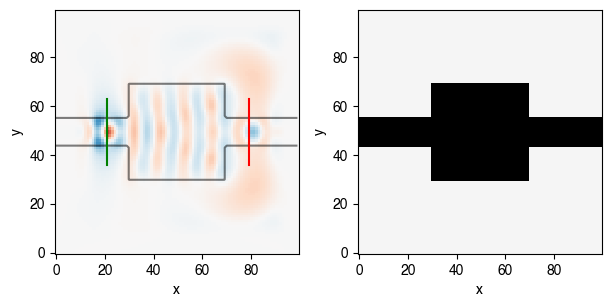

In [5]:
# Setup initial structure
rho_init, design_region, input_slice, output_slice = \
    init_domain(Nx, Ny, Npml, space=space, wg_width=wg_width, space_slice=space_slice)

epsr_init = epsr_min + (epsr_max-epsr_min) * rho_init

# Setup source
source = insert_mode(omega, dl, input_slice.x, input_slice.y, epsr_init, m=1)

# Setup probe
probe = insert_mode(omega, dl, output_slice.x, output_slice.y, epsr_init, m=2)

# Simulate initial device
simulation, ax = viz_sim(epsr_init)

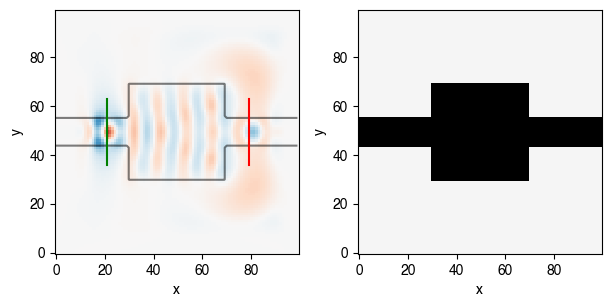

Epoch:   1/100 | Duration: 0.12 secs | Value: 1.544726e-13
Epoch:   2/100 | Duration: 0.11 secs | Value: 1.003286e-07
Epoch:   3/100 | Duration: 0.12 secs | Value: 2.018636e-07
Epoch:   4/100 | Duration: 0.11 secs | Value: 3.020135e-07
Epoch:   5/100 | Duration: 0.11 secs | Value: 3.993623e-07
Epoch:   6/100 | Duration: 0.11 secs | Value: 4.928770e-07
Epoch:   7/100 | Duration: 0.12 secs | Value: 5.818041e-07
Epoch:   8/100 | Duration: 0.12 secs | Value: 6.656485e-07
Epoch:   9/100 | Duration: 0.12 secs | Value: 7.441560e-07
Epoch:  10/100 | Duration: 0.12 secs | Value: 8.172875e-07
Epoch:  11/100 | Duration: 0.12 secs | Value: 8.851814e-07
Epoch:  12/100 | Duration: 0.12 secs | Value: 9.481121e-07
Epoch:  13/100 | Duration: 0.12 secs | Value: 1.006446e-06
Epoch:  14/100 | Duration: 0.11 secs | Value: 1.060603e-06
Epoch:  15/100 | Duration: 0.12 secs | Value: 1.111023e-06
Epoch:  16/100 | Duration: 0.11 secs | Value: 1.158140e-06
Epoch:  17/100 | Duration: 0.11 secs | Value: 1.202361e-

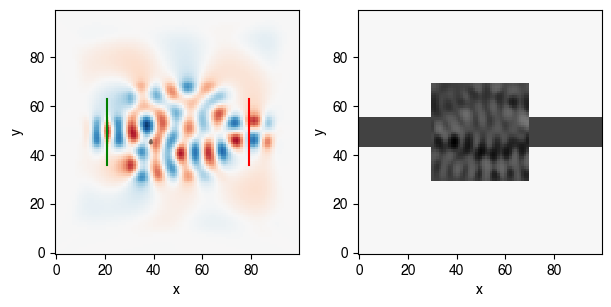

In [6]:
def measure_modes(Ez):
    """Defines an overlap integral between the sim field and desired field
    """
    return npa.abs(npa.sum(npa.conj(Ez)*probe))

def objective(epsr):
    """Objective function called by optimizer
    
    1) Takes the epsr distribution as input
    2) Runs the simulation
    3) Returns the overlap integral between the output wg field 
       and the desired mode field
    """
    epsr = epsr.reshape((Nx, Ny))
    
    dr_epsr = epsr * design_region
    bg_epsr = epsr_init * (design_region==0).astype(np.float)
    
    simulation.eps_r = dr_epsr + bg_epsr
    _, _, Ez = simulation.solve(source)
    return measure_modes(Ez)

# Simulate initial device
simulation, ax = viz_sim(epsr_init)

# Run optimization
objective_jac = jacobian(objective, mode='reverse')
(epsr_optimum, loss) = adam_optimize(objective, epsr_init.flatten(), objective_jac,
                         Nsteps=Nsteps, direction='max', step_size=step_size)
epsr_optimum = epsr_optimum.reshape((Nx, Ny))

# Simulate optimal device
simulation, ax = viz_sim(epsr_optimum)